# 03_Coverage

TODO: Bin evenly

Gini index: rank the bins by coverage (per cell)
Mean absolute deviation of coverage
insert size distribution per cell

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import tqdm
import pysam
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
results_dir = '/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [25]:
colon_dna_fn = '/broad/thechenlab/pipeline_slidetag/data/240609_SL-EXC_0308_A22KHFYLT3/count'
colon_rna_fn = '/broad/thechenlab/Benno/experiments/xBO153/cellranger'
colon_spatial_fn = '/broad/thechenlab/Andy/slide_tag_dna/colon_droplet/data/Mehdi_smaht_153_celltypes_locations.csv'
# bam_fn = '/broad/thechenlab/Benno/experiments/xBO153/cellranger/xBO153_GEX_240625/outs/possorted_genome_bam.bam' # RNA
bam_fn = '/broad/thechenlab/Benno/experiments/xBO153/bams/xBO153_G.markdup.bam' 
maf_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/data/xSDS_variants.txt'

# mapping barcodes
atac_bcs_fn = '/broad/thechenlab/Andy/software/cellranger-arc-2.0.2/lib/python/atac/barcodes/737K-arc-v1.txt.gz'
rna_bcs_fn = '/broad/thechenlab/Andy/software/cellranger-arc-2.0.2/lib/python/cellranger/barcodes/737K-arc-v1.txt.gz'

cytobands_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/refs/cytoBand.txt.gz'
convert_cb_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/refs/convert_cb.tsv'

In [5]:
with pysam.AlignmentFile(bam_fn, "rb") as bam:
    bam_header = bam.header.to_dict()

In [26]:
genome_bins_fn = f'{results_dir}/genome_bins.100k.bed'
genome_bins_fn

'/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/genome_bins.100k.bed'

In [38]:
bed_dfs = []
bin_size = 1_000_000 
for contig in bam_header['SQ']:
    contig_name = contig['SN']
    contig_len = contig['LN']
    
    bins = np.arange(0, contig_len + bin_size, bin_size)
    bed_df = pd.DataFrame({'chr': [contig_name] * (len(bins) - 1), 'start': bins[:-1], 'end': bins[1:]})
    bed_dfs.append(bed_df)
all_bed_dfs = pd.concat(bed_dfs)

In [39]:
all_bed_dfs.to_csv(genome_bins_fn, sep='\t', header=None, index=None)

In [40]:
binned_depth_fn = f'{results_dir}/binned_depth.1M.txt'
binned_depth_fn

'/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/binned_depth.1M.txt'

NOT separated by CB
```bash
use UGER
use Anaconda
use .samtools-1.9
samtools depth -a -b /broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/genome_bins.100k.bed  /broad/thechenlab/Benno/experiments/xBO153/bams/xBO153_G.markdup.bam > /broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/binned_depth.100k.txt
```

In [41]:
genome_bins_df = pd.read_csv(genome_bins_fn, sep='\t', header=None)
genome_bins_df.columns = ['chr', 'start', 'end']

In [42]:
genome_bins_df.shape

(3103, 3)

Ran `sandbox/qsub_3_coverage_CB.sh` in separate interactive session

In [6]:
fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/binned_coverage.by_CB.txt'
bed_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/03/binned_coverage.by_CB.all_beds.tsv'
df = pd.read_csv(fn, sep='\t', index_col=[0, 1])
bed_df = pd.read_csv(bed_fn, sep='\t', index_col=0)

In [7]:
reformat_df = df.sort_index().unstack()['0']

In [99]:
full_df = pd.concat([bed_df, reformat_df], axis=1)

In [100]:
full_df.tail()

,chr,start,end,AAACATGCTAAAGGTT,AAACATGCTAAATACG,AAACATGCTAACAGGC,AAACATGCTAACCTTG,AAACATGCTAACTCAC,AAACATGCTAAGCACG,AAACATGCTAAGGACC,...,TTTGTGTGATTGCATT,TTTGTGTGATTGCTAT,TTTGTGTGATTGCTCG,TTTGTGTGATTGGCGG,TTTGTGTGATTGTGGA,TTTGTGTGATTGTTTG,TTTGTGTGATTTGAGG,TTTGTGTGATTTGCAT,TTTGTGTGATTTGCTA,TTTGTGTGATTTGGAG
3098,chrY,54000000,55000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3099,chrY,55000000,56000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3100,chrY,56000000,57000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3101,chrY,57000000,58000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3102,chrM,0,1000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
reformat_df.shape

(2971, 410397)

In [14]:
barcode_sums = reformat_df.sum().sort_values()

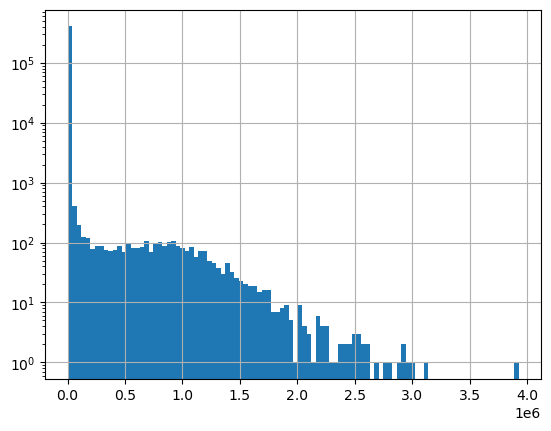

In [21]:
barcode_sums.hist(bins=100)
plt.yscale('log')
plt.show()

In [24]:
barcode_sums[barcode_sums > 1000]

ACAGCCTTGCAATGAA       1001.0
GTCACCATGATCAGCC       1001.0
CGATAAGCTAGTAACA       1001.0
AGCGATTACATACCGA       1001.0
GACCAAGCTGGAAACC       1001.0
                      ...    
GCCATAAACTGAGTGC    2940655.0
GCCTATTGATAACGTG    2947318.0
GATGTAACTCAAACTT    3005066.0
GCGATTAACATTGACG    3126518.0
AAGTGAGGAACCTACT    3926765.0
Length: 45481, dtype: float64

In [42]:
convert_cb_df = pd.read_csv(convert_cb_fn, sep='\t')
colon_spatial_df = pd.read_csv(colon_spatial_fn, sep=',', index_col=0)

In [48]:
colon_spatial_df.loc[]

,cell_type,x,y,cell_type_broad
AAACCGAAGGCAATAG-1,Intermediate Epithelial,NaN,NaN,Epithelial
AAACCGAAGTATCGCG-1,Progenitor Epithelial,4639.436632,3248.049118,Epithelial
AAACCGGCATCTTGAG-1,T cell,NaN,NaN,Immune
AAACGCGCATGGAGGC-1,Fibroblast_1,2043.568952,1025.101805,Stromal
AAACGGATCATGCTTT-1,Goblet,4539.478596,3205.408255,Epithelial
...,...,...,...,...
TTTGGTAAGGAGCACG-1,Fibroblast_1,NaN,NaN,Stromal
TTTGTGAAGCATGAAG-1,Goblet,1923.926680,1428.126448,Epithelial
TTTGTGAAGGACCAGG-1,Progenitor Epithelial,NaN,NaN,Epithelial
TTTGTGTTCCGTGACA-1,Progenitor Epithelial,3482.962226,2015.009358,Epithelial


In [51]:
cb_df = convert_cb_df.set_index('CB').copy()
subset_idx = (cb_df['RNA'] + '-1').isin(colon_spatial_df.index)
cb_df.loc[subset_idx, colon_spatial_df.columns.tolist()] = colon_spatial_df.loc[(cb_df.loc[subset_idx, 'RNA'] + '-1').tolist()].to_numpy()

In [52]:
cb_df.loc[subset_idx]

,ATAC,RNA,cell_type,x,y,cell_type_broad
CB,,,,,,
TGTGATGGAATAGTCA,TGACTATTCCATCACA,AAACCGAAGGCAATAG,Intermediate Epithelial,NaN,NaN,Epithelial
TACGGGCGAATAGTCA,TGACTATTCGCCCGTA,AAACCGAAGTATCGCG,Progenitor Epithelial,4639.436632,3248.049118,Epithelial
CAGGATCACGGTCAAT,ATTGACCGTGATCCTG,AAACCGGCATCTTGAG,T cell,NaN,NaN,Immune
GTACCTCACGGGTTAT,ATAACCCGTGAGGTAC,AAACGCGCATGGAGGC,Fibroblast_1,2043.568952,1025.101805,Stromal
GGCCTCACTAGGCCTC,GAGGCCTAGTGAGGCC,AAACGGATCATGCTTT,Goblet,4539.478596,3205.408255,Epithelial
...,...,...,...,...,...,...
CGAACTAGAGCTATCT,AGATAGCTCTAGTTCG,TTTGGTAAGGAGCACG,Fibroblast_1,NaN,NaN,Stromal
GTTCACTGACACCTAC,GTAGGTGTCAGTGAAC,TTTGTGAAGCATGAAG,Goblet,1923.926680,1428.126448,Epithelial
TAGCACAGACACCTAC,GTAGGTGTCTGTGCTA,TTTGTGAAGGACCAGG,Progenitor Epithelial,NaN,NaN,Epithelial


<Axes: >

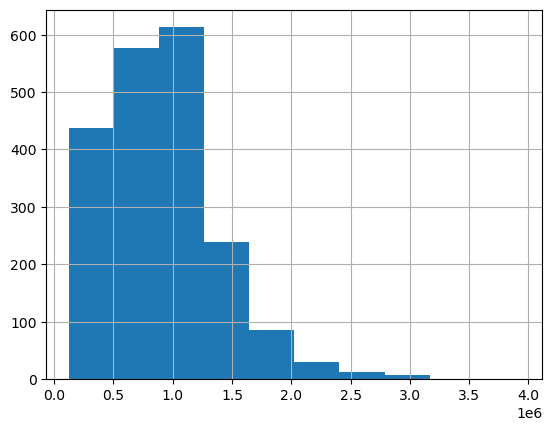

In [59]:
barcode_sums[cb_df.loc[subset_idx].index].hist()

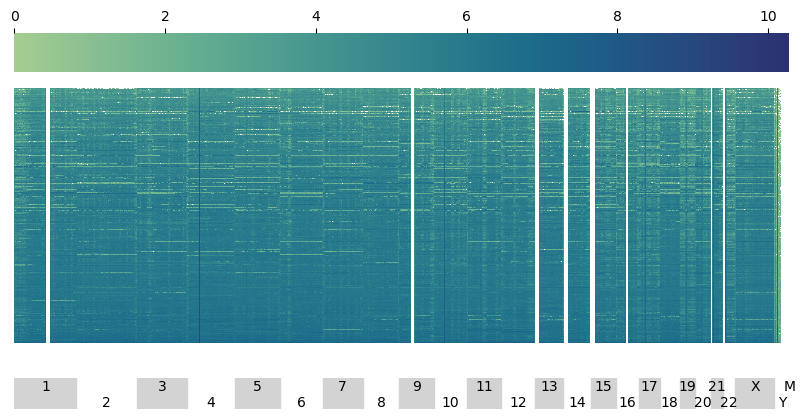

In [102]:
fig, axes = plt.subplots(2, figsize=(10, 5), height_ratios=(10, 1), sharex=True)
sns.heatmap(np.log(full_df[barcode_sums[cb_df.loc[subset_idx].index].sort_values().index]).T, cmap='crest', ax=axes[0], cbar_kws=dict(location='top'))
axes[0].set_yticks([])
axes[0].set_xticks([])

axes[1].set_yticks([])
axes[1].set_xticks([])

i = 0
axes[1].axis('off')
for contig in bed_df['chr'].unique():
    contig_regions_idx = bed_df.query(f"chr == '{contig}'").index
    if i % 2 == 0:
        axes[1].axvspan(contig_regions_idx[0], contig_regions_idx[-1], color='lightgray')
        text_height = 0.7 
    else:
        text_height = 0.2
    axes[1].text(np.mean(contig_regions_idx), text_height, contig.strip('chr'), ha='center', va='center')
    i += 1
plt.show()

In [110]:
full_df.loc[bed_df.query('chr == "chr4"').index, barcode_sums[cb_df.loc[subset_idx].index].sort_values().index]

CB,GTGTAATGAGGAACAA,TTACAACCTAACTCAC,CATGGTCCTCACTTGG,AACTGAGTGCTTCCTG,TAGCCCTGAGCAAGGG,ACCTCATGACAGGCTG,AACCATGACGTTTCGC,TATATCGCTAAGCTTC,TCGTGACCTATGTGGG,CGTCCCTCTAGGTTAA,...,GCATGAGCTCCTACTT,ACCTTTAACAGCACGC,AACCATGACCGCCCAT,CCGATTATGTAAGCGG,CTAATGCTGTGGAGCA,GCCATAAACTGAGTGC,GCCTATTGATAACGTG,GATGTAACTCAAACTT,GCGATTAACATTGACG,AAGTGAGGAACCTACT
691,20.0,36.0,63.0,57.0,4.0,35.0,22.0,31.0,14.0,40.0,...,705.0,711.0,930.0,1266.0,751.0,770.0,969.0,727.0,897.0,1411.0
692,12.0,18.0,35.0,37.0,18.0,8.0,21.0,28.0,22.0,14.0,...,672.0,465.0,747.0,1039.0,402.0,672.0,640.0,192.0,561.0,975.0
693,20.0,35.0,8.0,17.0,12.0,6.0,22.0,21.0,6.0,24.0,...,609.0,426.0,996.0,1192.0,648.0,662.0,1085.0,429.0,652.0,1225.0
694,34.0,48.0,46.0,13.0,18.0,4.0,27.0,29.0,14.0,12.0,...,608.0,403.0,1012.0,1212.0,575.0,823.0,812.0,311.0,549.0,874.0
695,36.0,40.0,61.0,66.0,14.0,16.0,32.0,23.0,6.0,41.0,...,780.0,492.0,893.0,1071.0,725.0,887.0,1037.0,605.0,741.0,995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,40.0,75.0,40.0,45.0,16.0,32.0,76.0,47.0,64.0,50.0,...,1143.0,862.0,1009.0,973.0,791.0,1052.0,1097.0,1445.0,773.0,1422.0
878,40.0,69.0,45.0,67.0,24.0,44.0,53.0,70.0,36.0,46.0,...,1110.0,694.0,1118.0,1010.0,861.0,1123.0,1163.0,1473.0,784.0,1470.0
879,43.0,74.0,40.0,76.0,54.0,35.0,52.0,56.0,49.0,83.0,...,941.0,703.0,878.0,1077.0,866.0,1074.0,916.0,1391.0,641.0,1402.0
880,43.0,55.0,50.0,109.0,54.0,72.0,63.0,34.0,52.0,49.0,...,1079.0,785.0,1149.0,1043.0,897.0,1172.0,1014.0,1544.0,709.0,1537.0


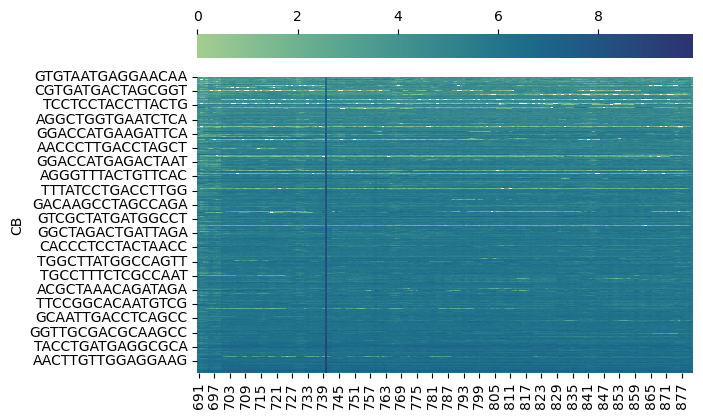

In [111]:
sns.heatmap(np.log(full_df.loc[bed_df.query('chr == "chr4"').index, barcode_sums[cb_df.loc[subset_idx].index].sort_values().index]).T, cmap='crest', cbar_kws=dict(location='top'))
plt.show()

([], [])

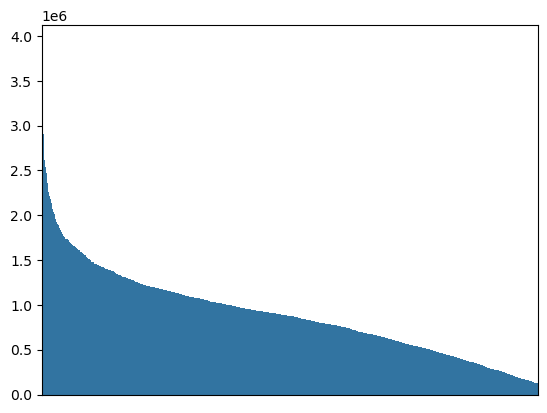

In [77]:
sorted_cb_counts = barcode_sums[cb_df.loc[subset_idx].index].sort_values(ascending=False)
sns.barplot(x=np.arange(len(sorted_cb_counts)), y=sorted_cb_counts.values, width=1.0)
plt.xticks([])

In [64]:
barcode_sums.shape

(410397,)